In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
from datetime import datetime, timedelta

# --- 데이터 로드 ---
try:
    df_agv = pd.read_csv(r"C:\Users\82102\OneDrive\바탕 화면\경희대학교\교외활동\스마트 항만 AGV 경로 최적화\agv.csv")
    df_task = pd.read_csv(r"C:\Users\82102\OneDrive\바탕 화면\경희대학교\교외활동\스마트 항만 AGV 경로 최적화\task.csv")

    # 분석할 submission 파일을 아래에 지정하세요.
    submission_file = r"C:\Users\82102\OneDrive\바탕 화면\경희대학교\교외활동\스마트 항만 AGV 경로 최적화\VNS_inital_18241.csv"
    df_submission = pd.read_csv(submission_file)
except FileNotFoundError as e:
    print(f"오류: 파일 '{e.filename}'을 찾을 수 없습니다. 스크립트와 동일한 디렉토리에 파일이 있는지 확인하세요.")
    exit()

'C:\Users\82102\OneDrive\바탕 화면\경희대학교\교외활동\스마트 항만 AGV 경로 최적화\VNS_inital_18241.csv' 파일에 대한 분석을 시작합니다.


C:\Users\82102\AppData\Local\Temp\ipykernel_30624\3309836338.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



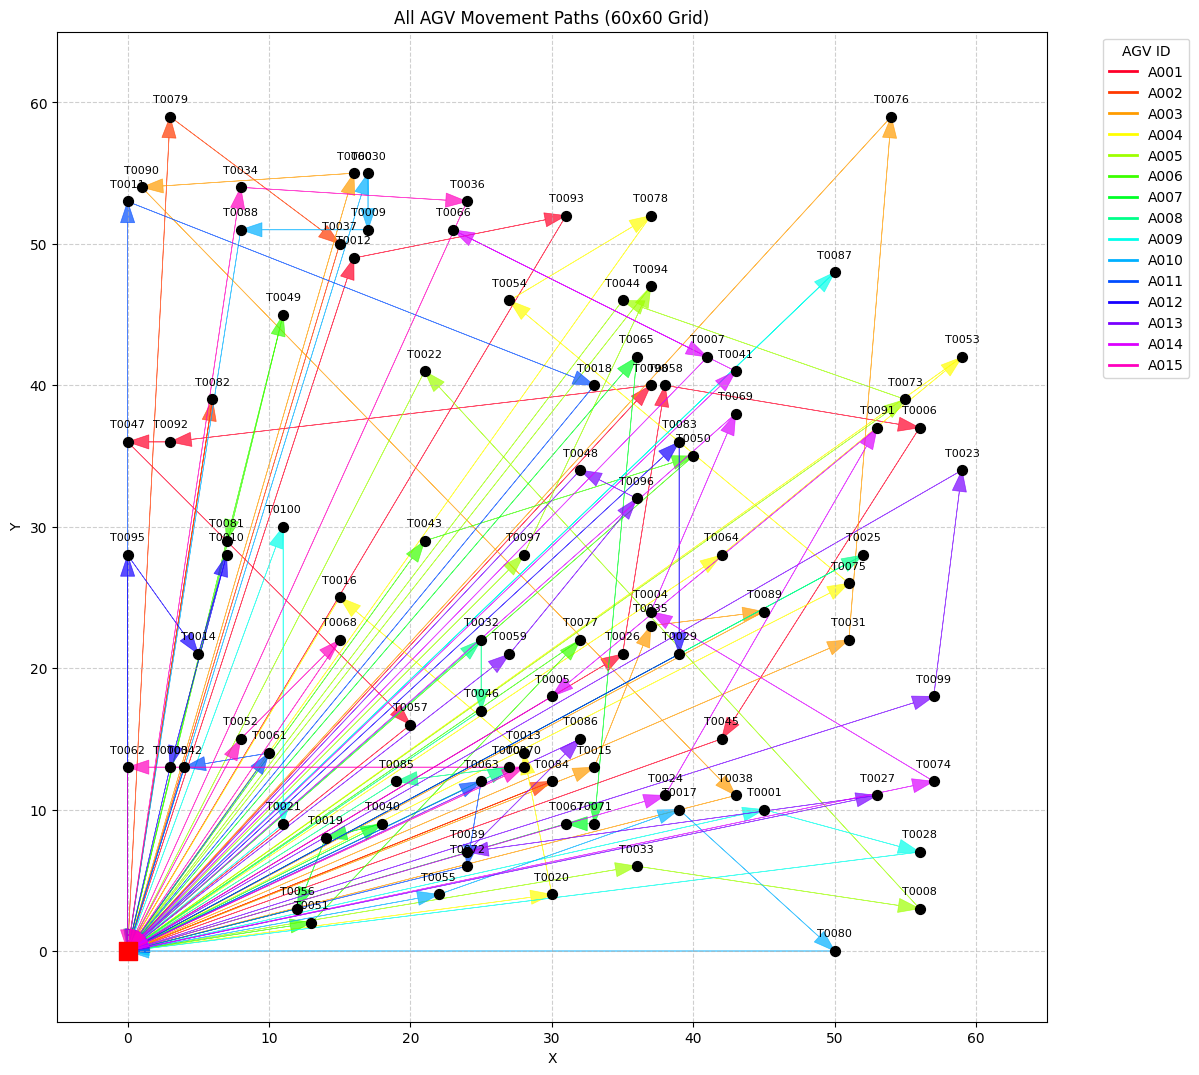

C:\Users\82102\AppData\Local\Temp\ipykernel_30624\3309836338.py:69: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



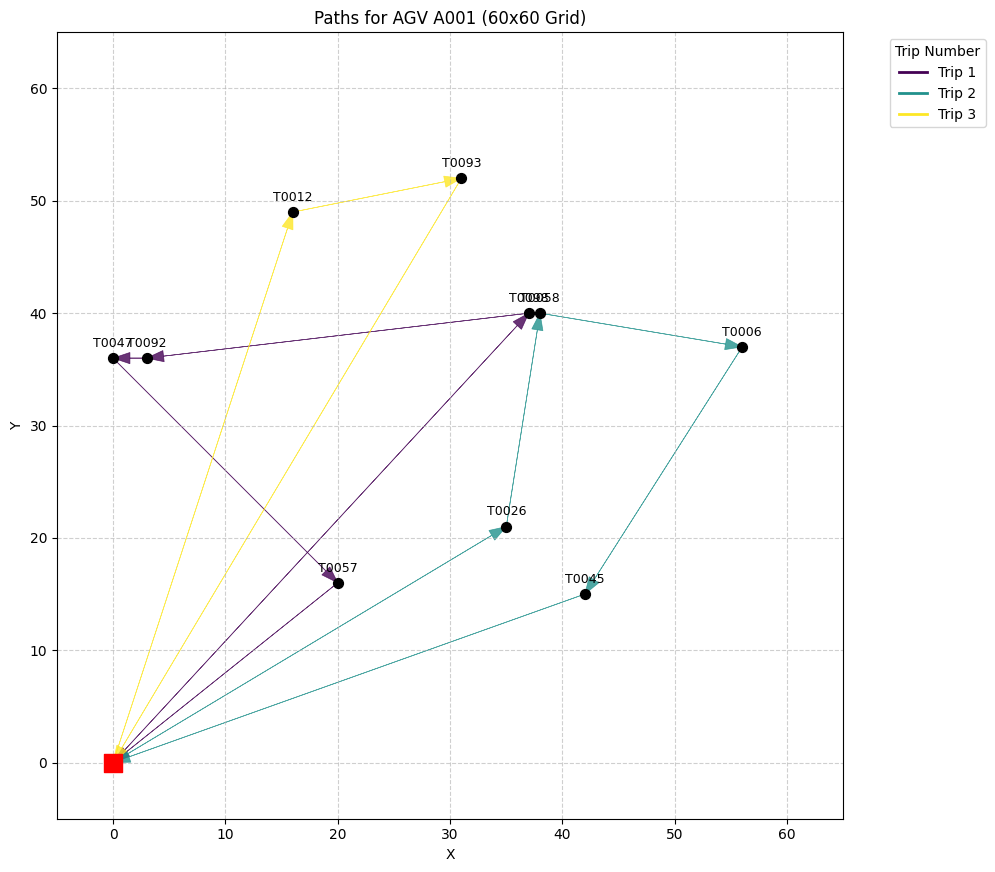

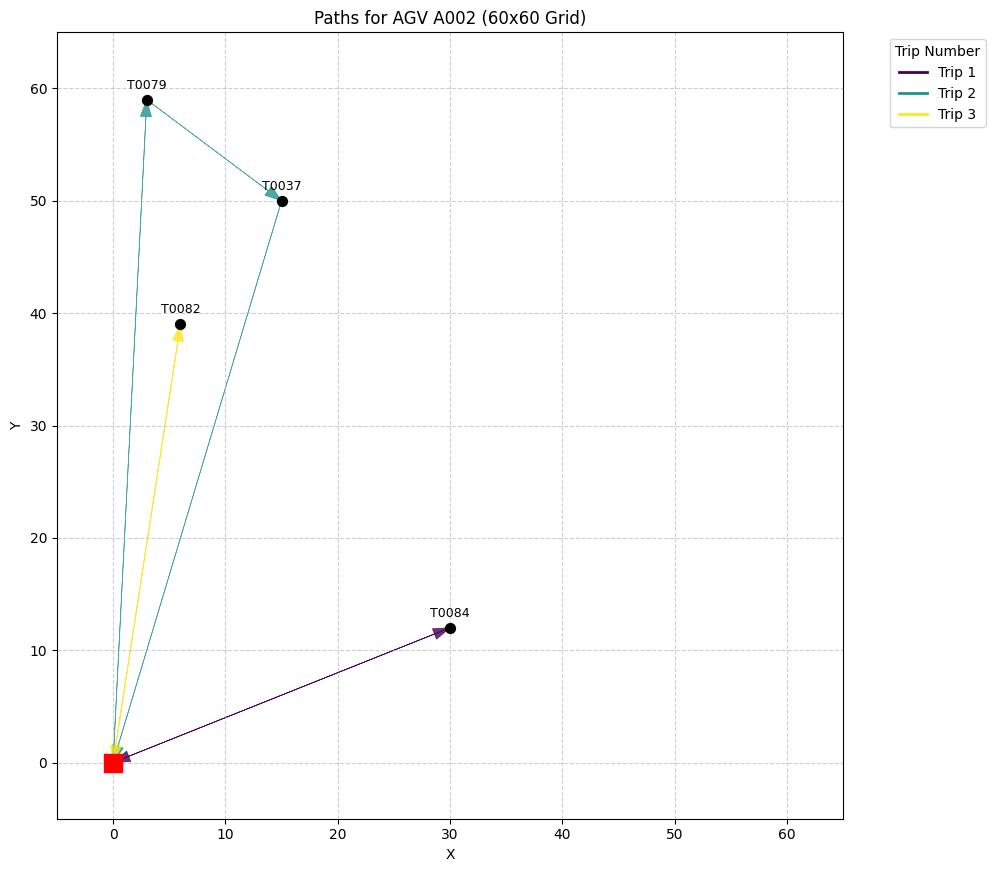

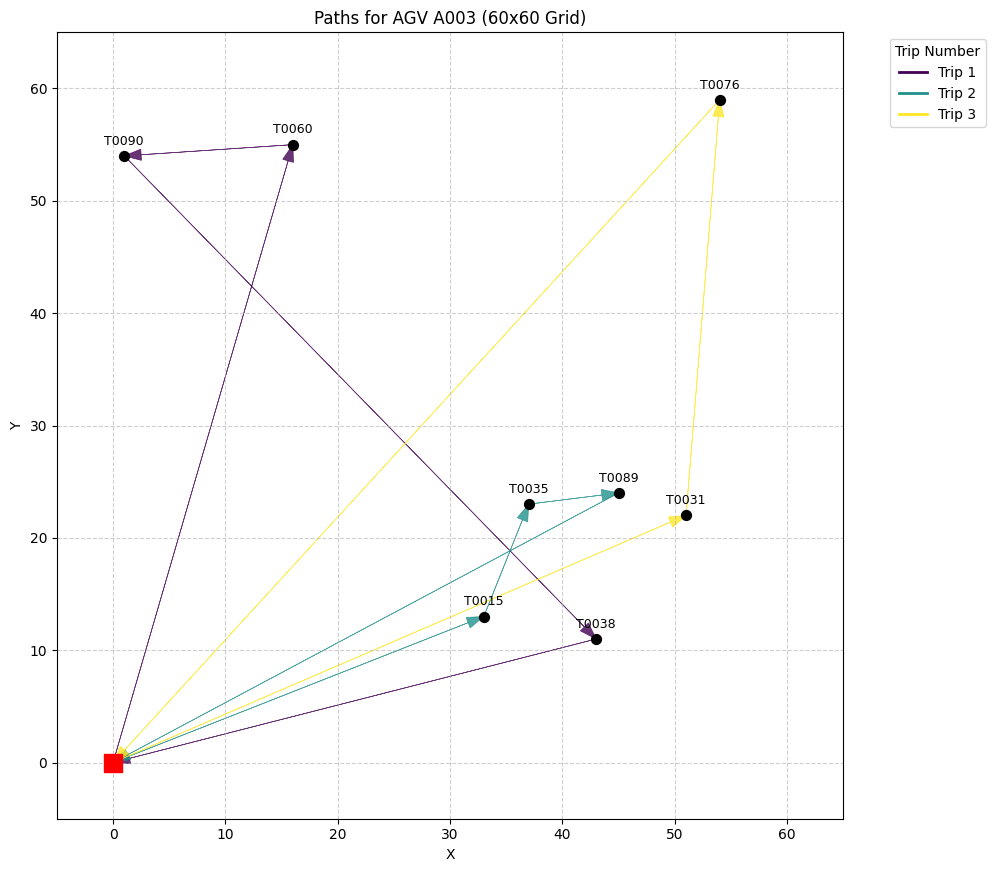

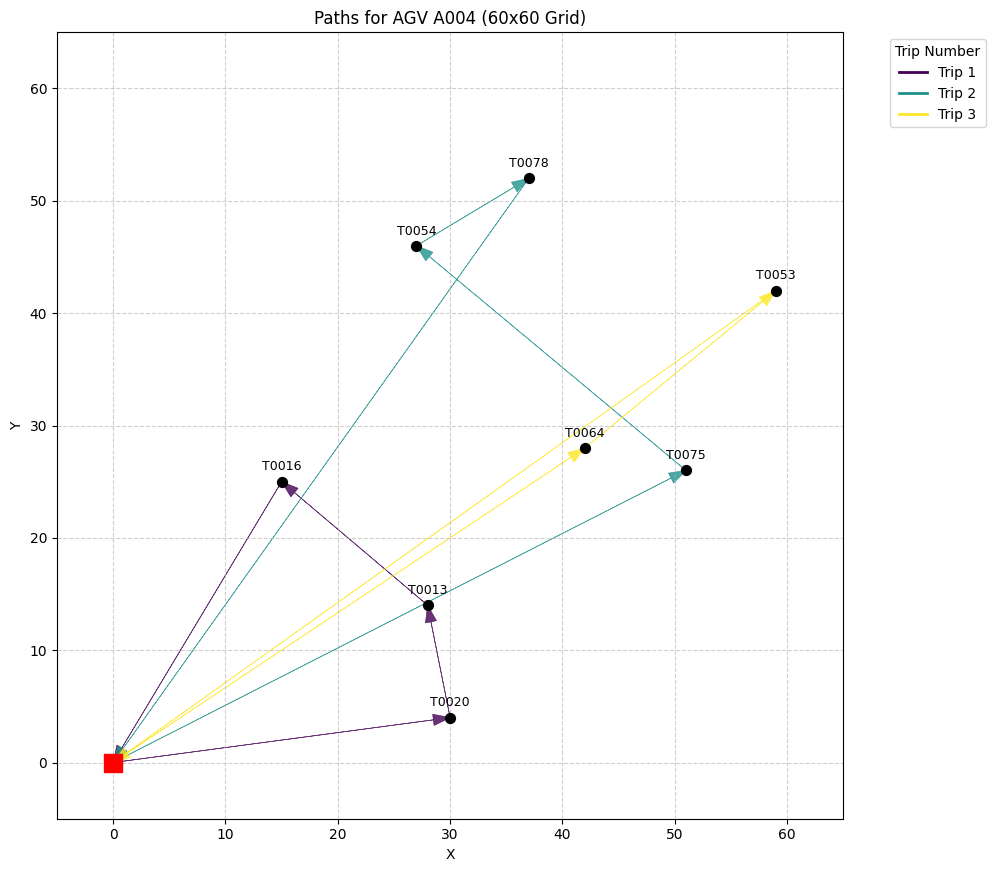

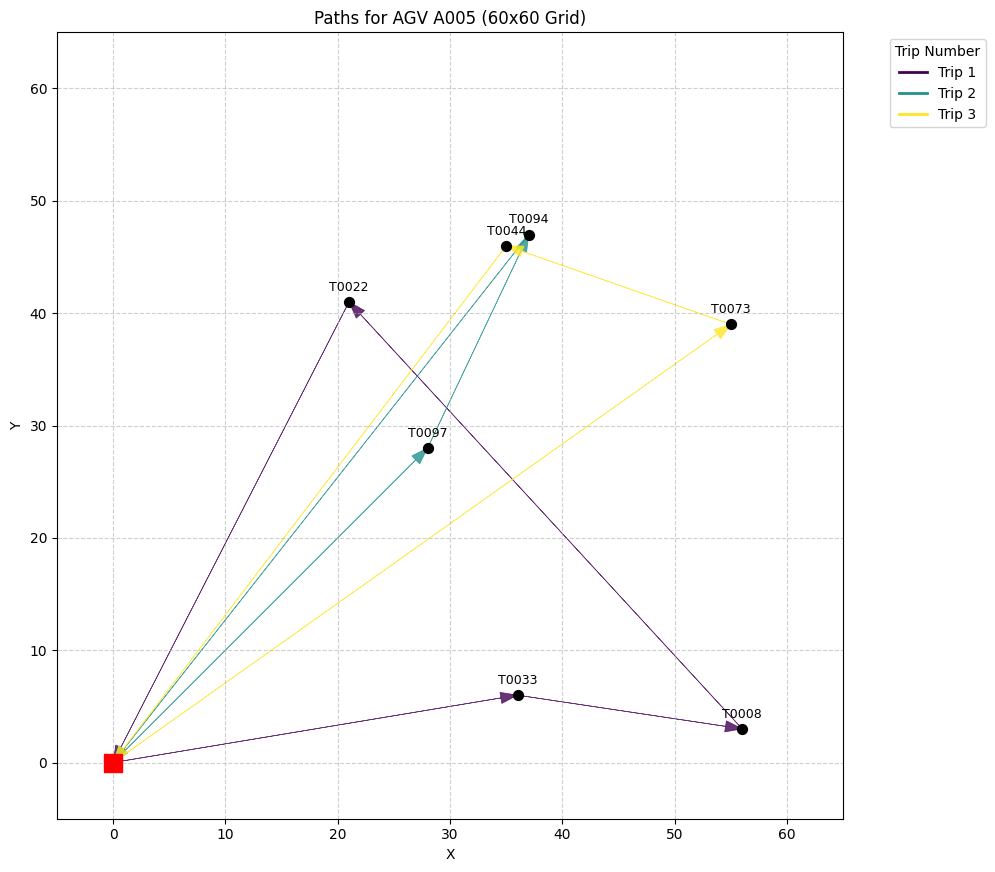

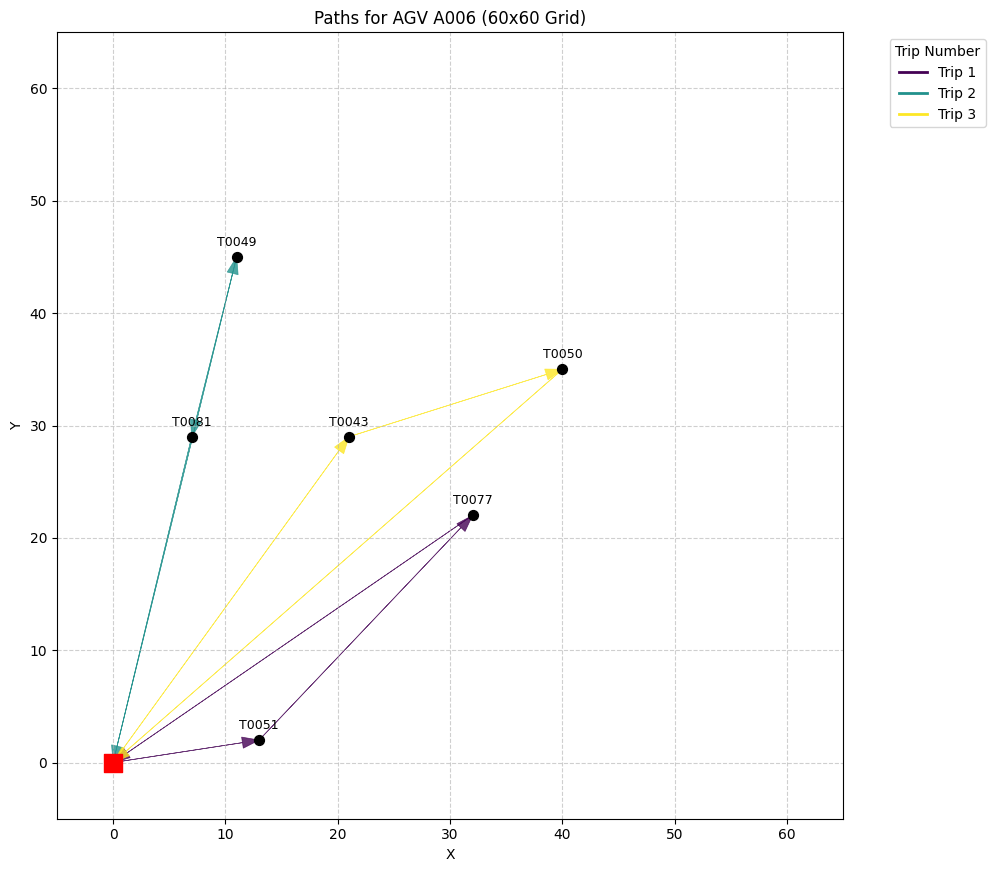

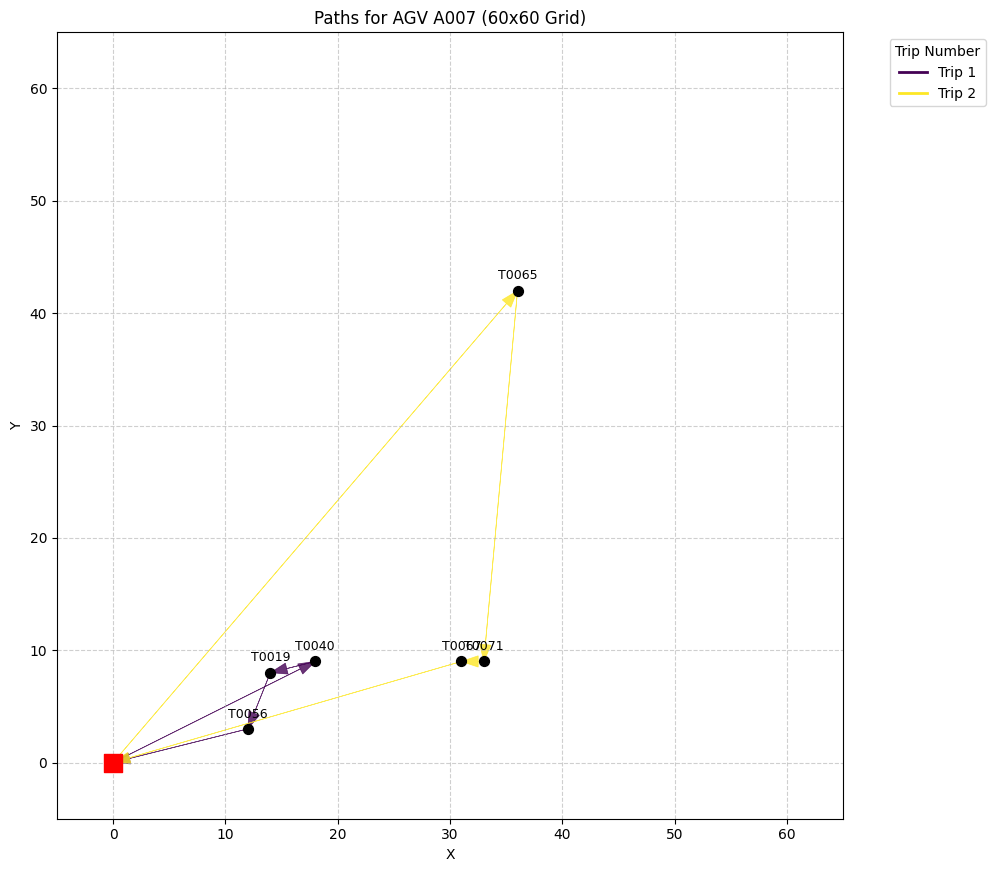

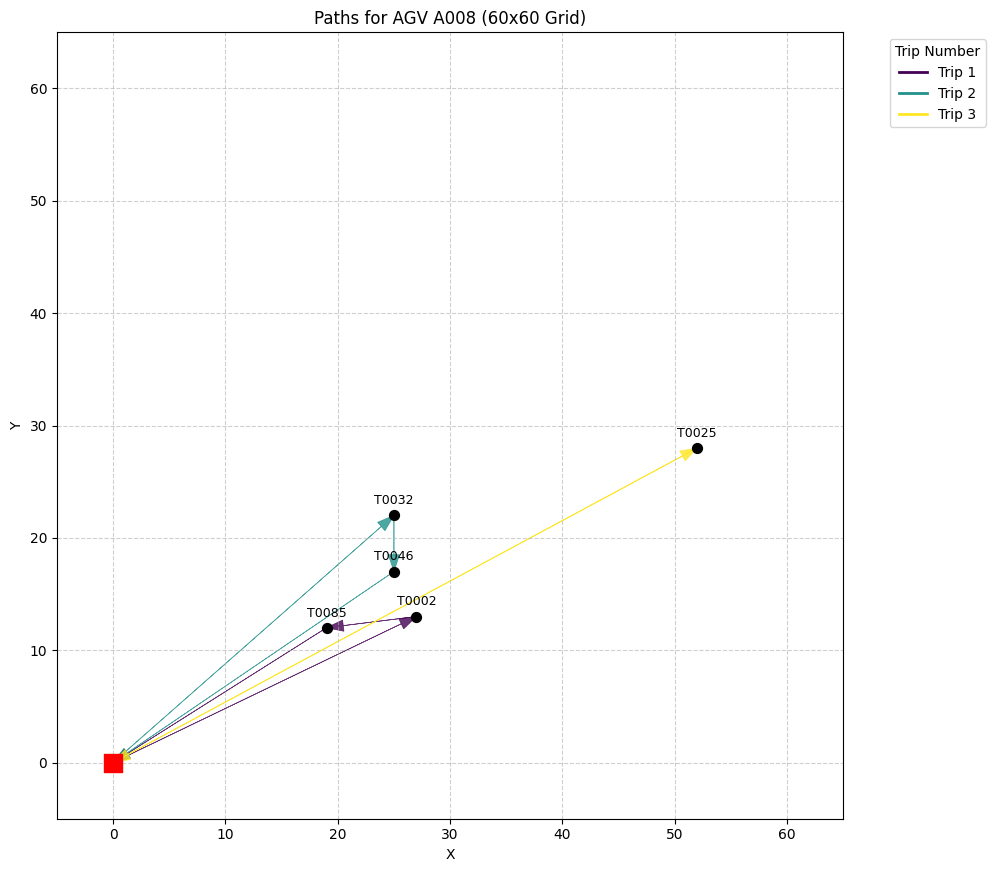

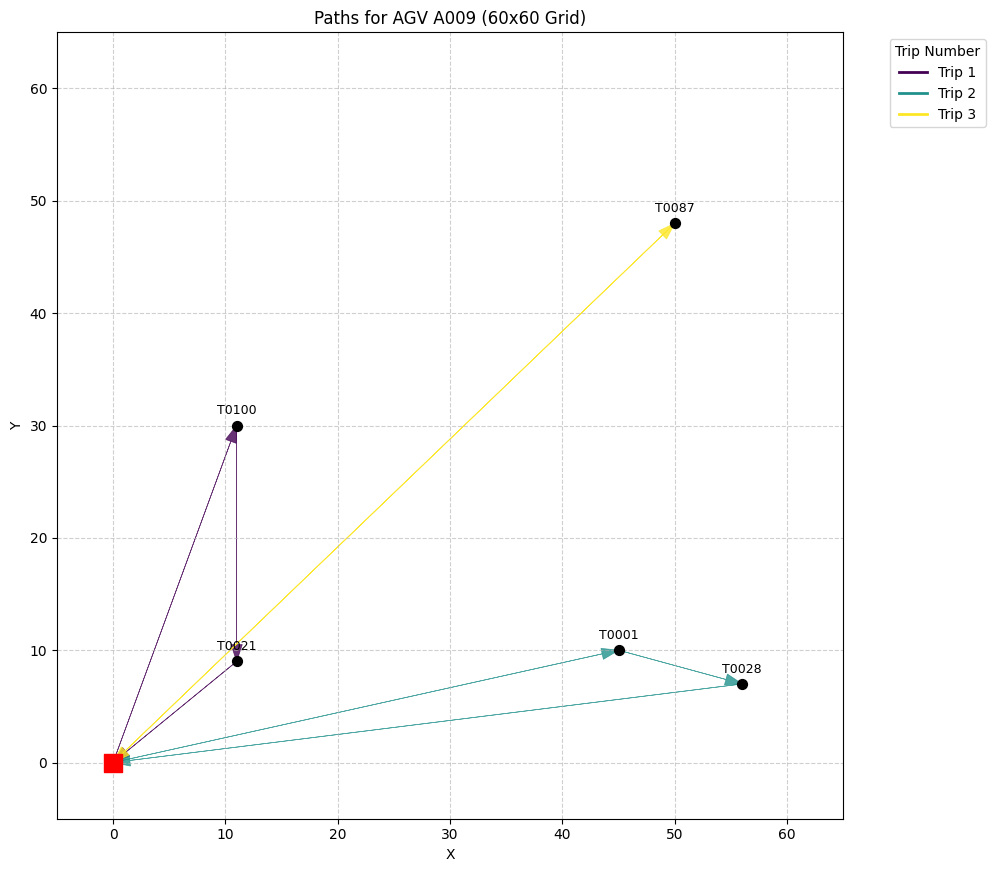

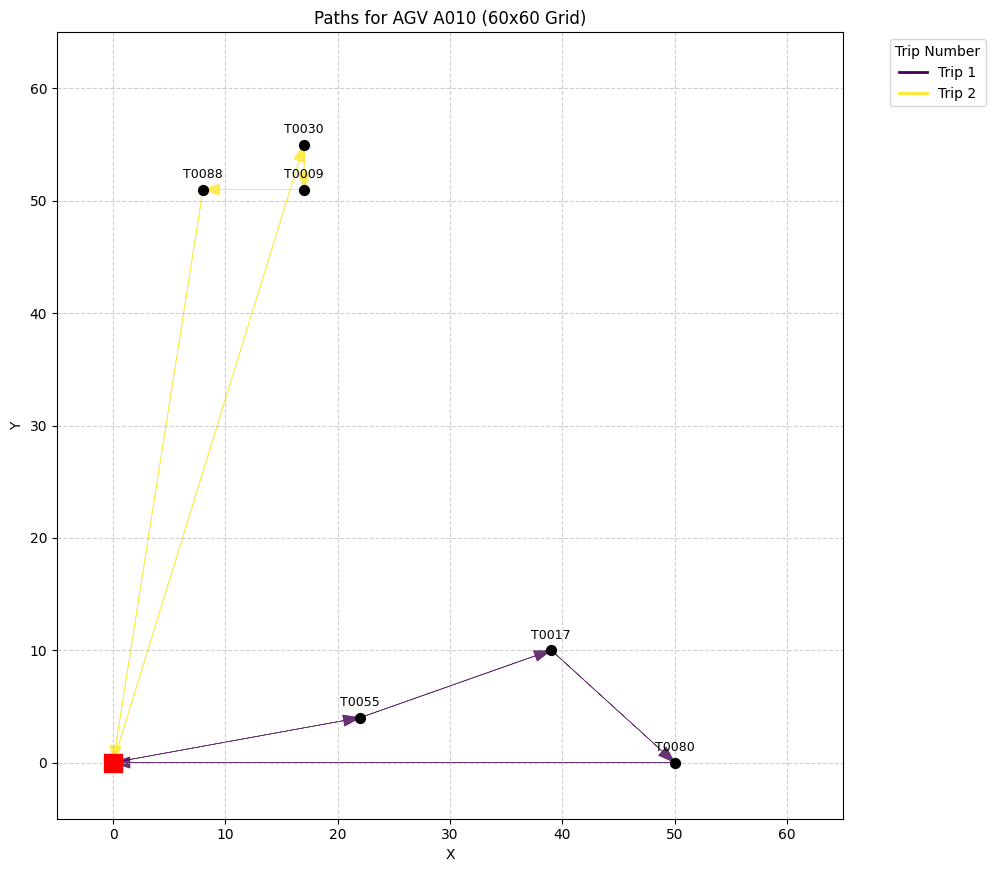

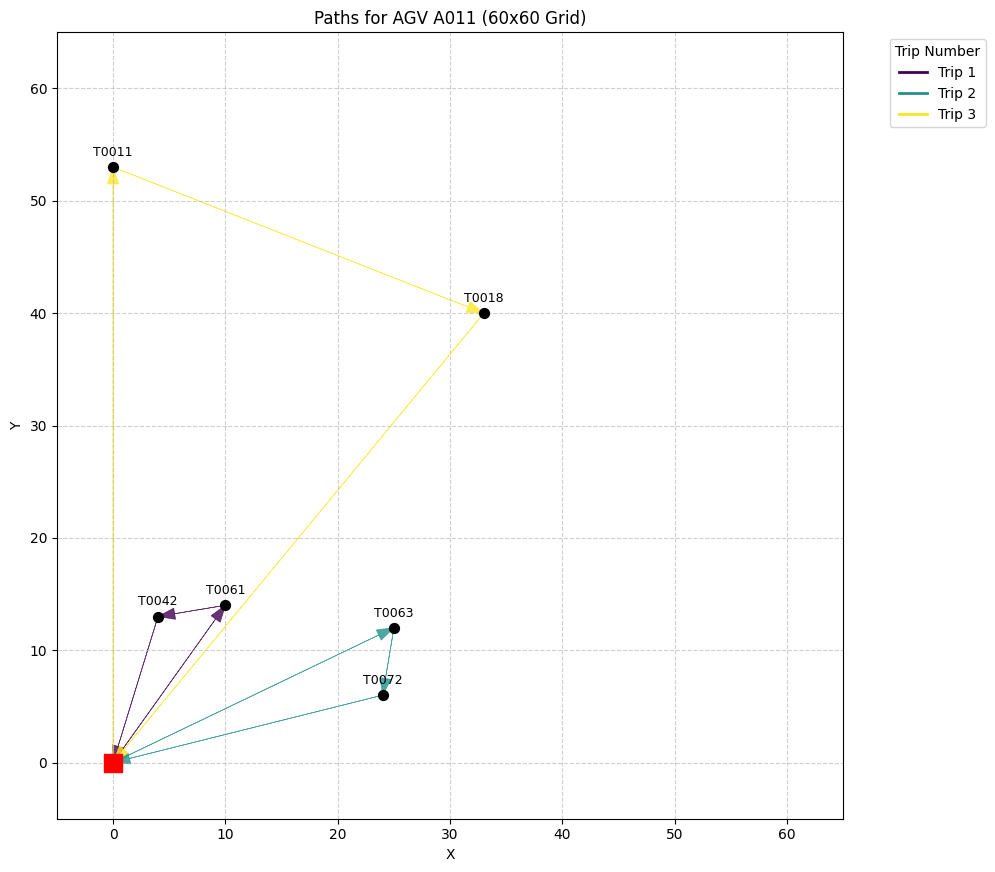

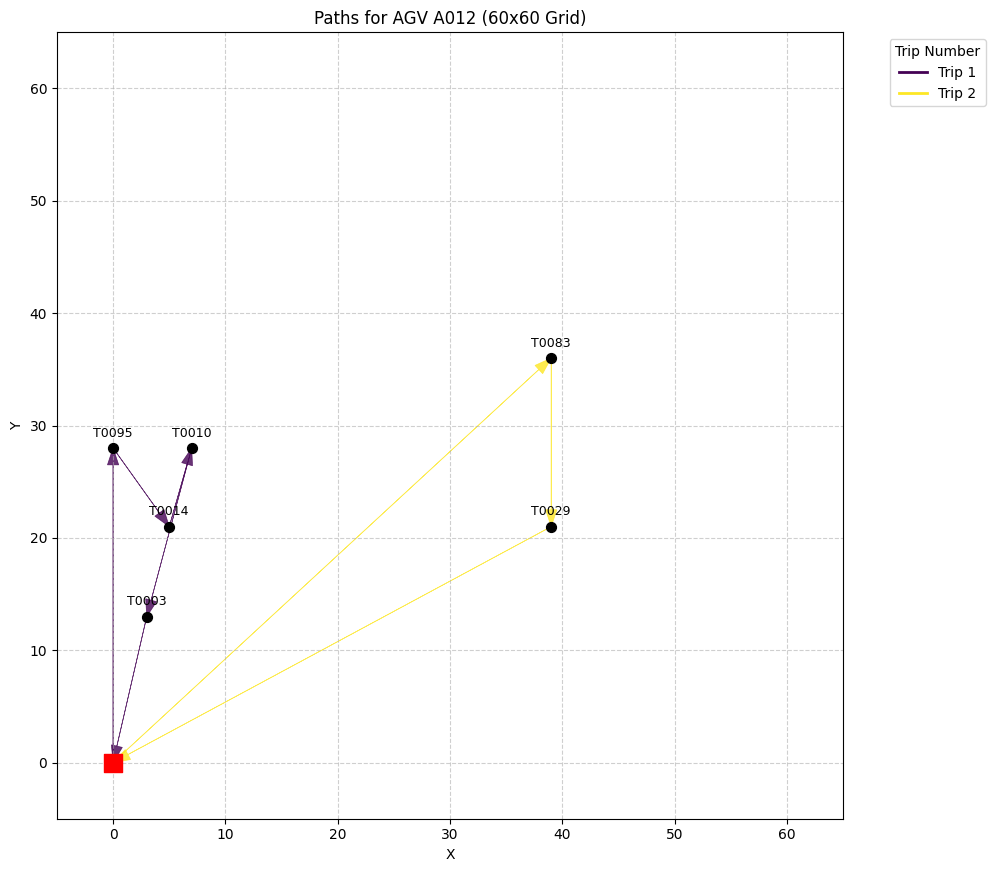

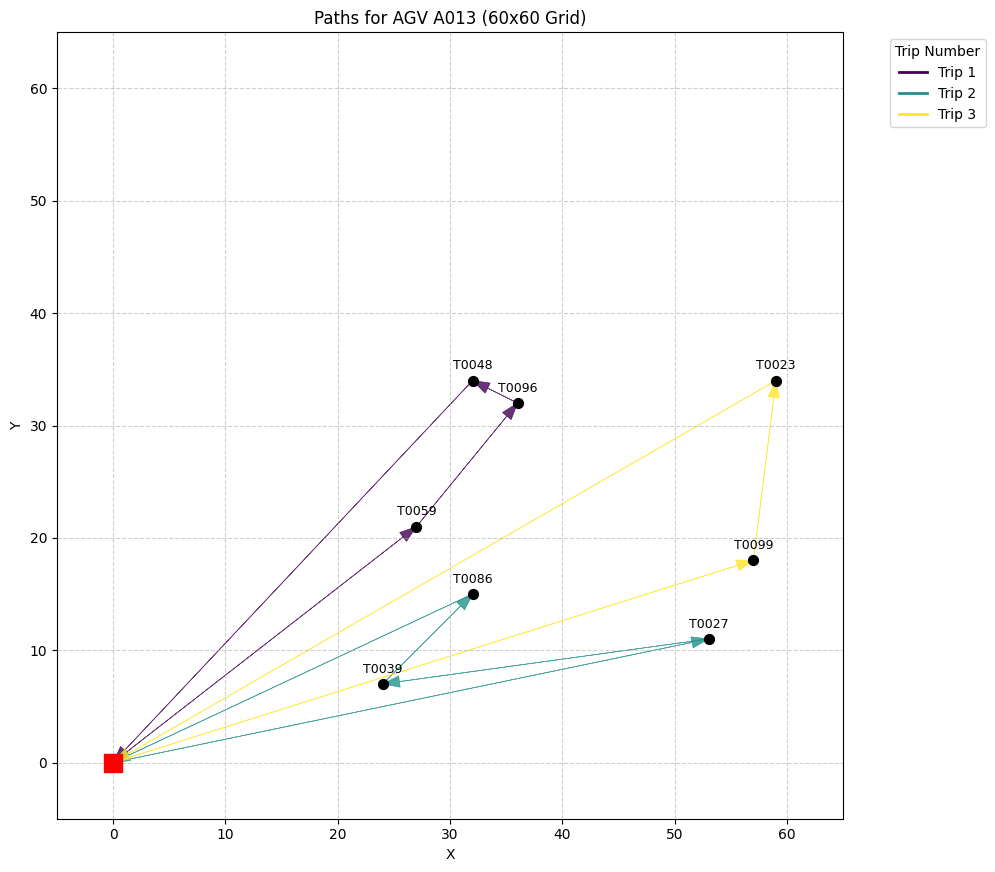

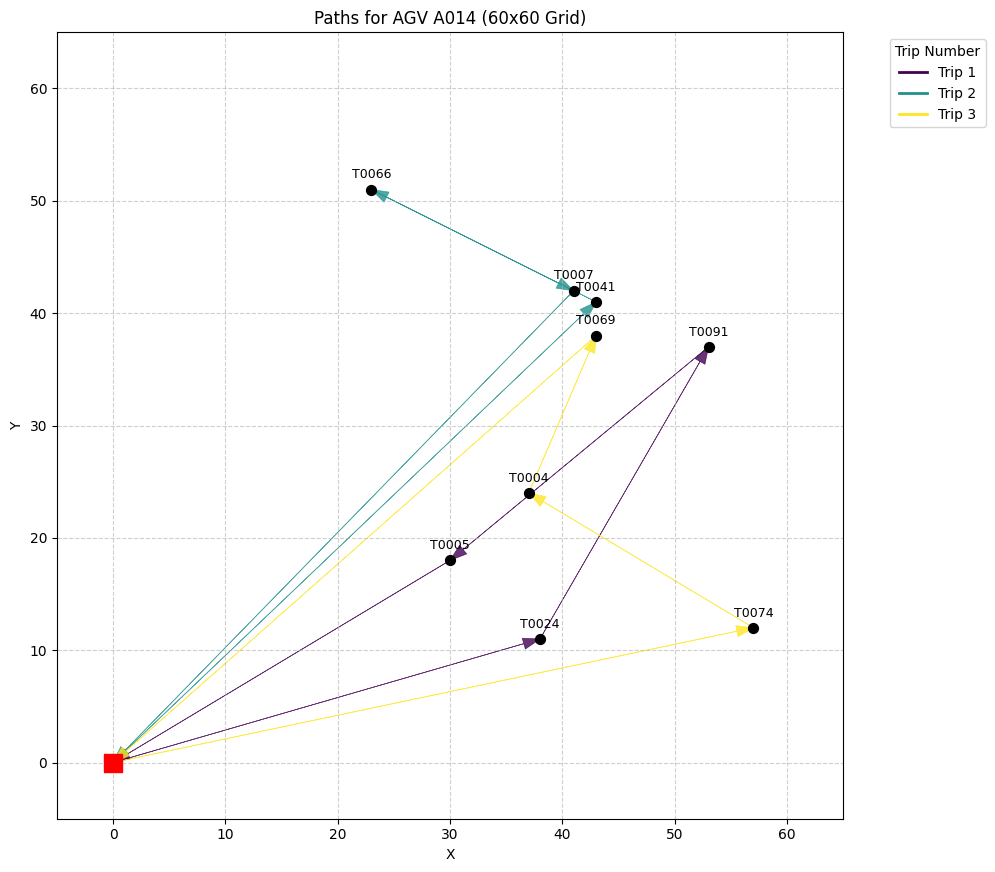

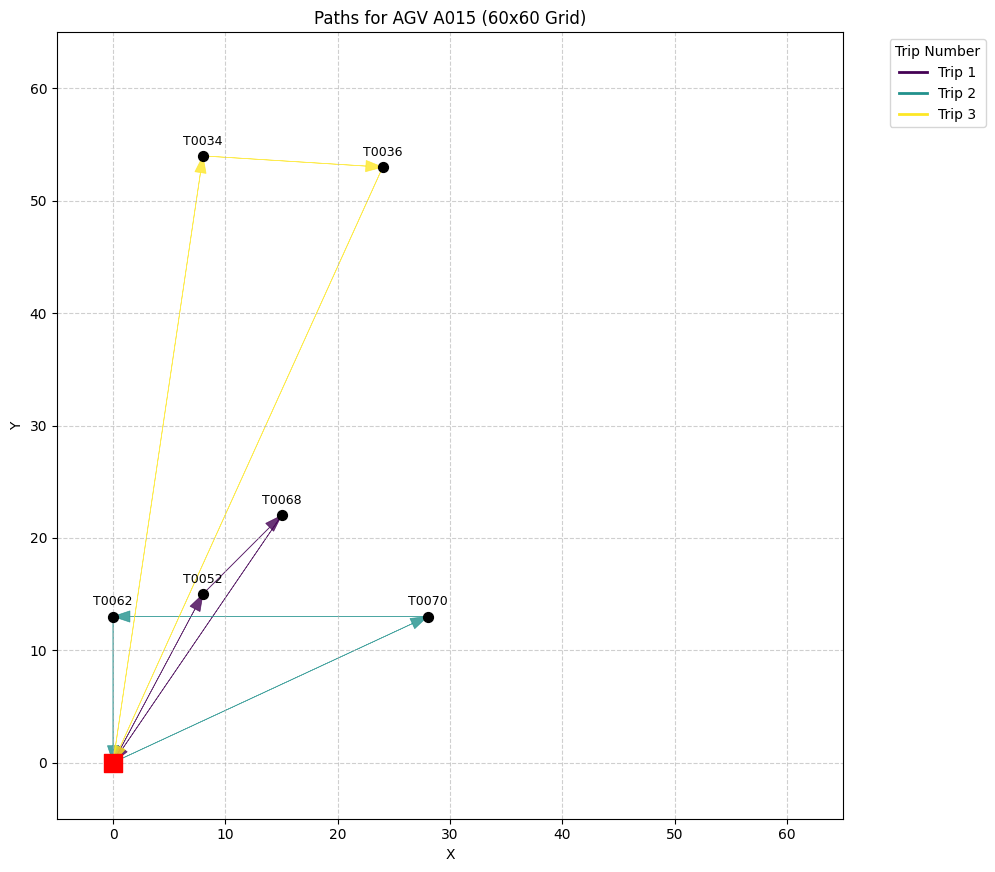

--- Violation Report ---

[AGV ID: A001]
  - Task Lateness:
    - Task T0058: Late by 2.00초
    - Task T0045: Late by 103.50초
    - Task T0012: Late by 237.50초
    - Task T0093: Late by 247.50초
  - Trip Capacity:
    - Trip 1 [T0098, T0092, T0047, T0057]: OK (Demand: 7 <= Capacity: 7)
    - Trip 2 [T0026, T0058, T0006, T0045]: OK (Demand: 7 <= Capacity: 7)
    - Trip 3 [T0012, T0093]: OK (Demand: 4 <= Capacity: 7)

[AGV ID: A002]
  - Task Lateness:
    - Task T0082: Late by 61.00초
  - Trip Capacity:
    - Trip 1 [T0084]: OK (Demand: 3 <= Capacity: 3)
    - Trip 2 [T0079, T0037]: OK (Demand: 3 <= Capacity: 3)
    - Trip 3 [T0082]: OK (Demand: 3 <= Capacity: 3)

[AGV ID: A003]
  - Task Lateness:
    - Task T0015: Late by 9.00초
    - Task T0035: Late by 24.00초
    - Task T0089: Late by 46.50초
    - Task T0031: Late by 144.50초
    - Task T0076: Late by 155.50초
  - Trip Capacity:
    - Trip 1 [T0060, T0090, T0038]: OK (Demand: 7 <= Capacity: 7)
    - Trip 2 [T0015, T0035, T0089]: OK (Demand

분석 및 시각화가 완료되었습니다.


In [29]:
# --- 데이터 전처리 ---
task_dict = df_task.set_index('task_id').to_dict('index')
task_dict['DEPOT'] = {'x': 0, 'y': 0, 'service_time': 0, 'demand': 0, 'deadline': float('inf')}
agv_dict = df_agv.set_index('agv_id').to_dict('index')
analysis_results = []

# --- 경로 분석 및 계산 ---
for _, row in df_submission.iterrows():
    agv_id, agv_info = row['agv_id'], agv_dict[row['agv_id']]
    path = row['route'].split(',')
    cumulative_time, trip_num = 0, 0
    trips, current_trip = [], ['DEPOT']
    for point in path[1:]:
        current_trip.append(point)
        if point == 'DEPOT':
            if len(current_trip) > 2: trips.append(current_trip)
            current_trip = ['DEPOT']
    for trip_points in trips:
        trip_num += 1
        trip_demand = sum(task_dict[p]['demand'] for p in trip_points if p != 'DEPOT')
        capacity_violation = trip_demand > agv_info['capacity']
        for i in range(len(trip_points) - 1):
            start_point_id, end_point_id = trip_points[i], trip_points[i+1]
            start_coord, end_coord = task_dict[start_point_id], task_dict[end_point_id]
            distance = abs(start_coord['x'] - end_coord['x']) + abs(start_coord['y'] - end_coord['y'])
            travel_time = distance / agv_info['speed_cells_per_sec']
            arrival_time = cumulative_time + travel_time
            is_task = end_point_id != 'DEPOT'
            service_time = task_dict[end_point_id]['service_time'] if is_task else 0
            task_demand = task_dict[end_point_id]['demand'] if is_task else 0
            deadline = task_dict[end_point_id]['deadline'] if is_task else float('inf')
            completion_time = arrival_time + service_time
            lateness = max(0, completion_time - deadline)
            analysis_results.append({
                'agv_id': agv_id, 'trip_num': trip_num, 'start_point': start_point_id,
                'end_point': end_point_id, 'start_x': start_coord['x'], 'start_y': start_coord['y'],
                'end_x': end_coord['x'], 'end_y': end_coord['y'], 'arrival_time': arrival_time,
                'completion_time': completion_time, 'travel_time': travel_time, 'lateness_duration': lateness,
                'capacity_violation': capacity_violation, 'trip_demand': trip_demand,
                'task_demand': task_demand, 'agv_capacity': agv_info['capacity']
            })
            cumulative_time = completion_time
df_analysis = pd.DataFrame(analysis_results)

def get_status(row):
    is_late = row['lateness_duration'] > 0; is_overload = row['capacity_violation']
    if is_late and is_overload: return 'Late & Overload'
    if is_late: return 'Late'
    if is_overload: return 'Overload'
    return 'On-time'
if not df_analysis.empty: df_analysis['status'] = df_analysis.apply(get_status, axis=1)

# --- 1 & 2. 경로 시각화 ---
def plot_all_agv_paths(df, task_info):
    plt.figure(figsize=(12, 12)); agv_ids = df['agv_id'].unique()
    colors = plt.cm.get_cmap('gist_rainbow', len(agv_ids)); agv_colors = {agv_id: colors(i) for i, agv_id in enumerate(agv_ids)}
    for agv_id, group in df.groupby('agv_id'):
        for _, row in group.iterrows():
            dx, dy = row['end_x'] - row['start_x'], row['end_y'] - row['start_y']
            if dx != 0 or dy != 0: plt.arrow(row['start_x'], row['start_y'], dx, dy, color=agv_colors[agv_id], alpha=0.7, head_width=1.0, head_length=1.5, length_includes_head=True, lw=0.5)
    for task_id, info in task_info.items():
        if task_id != 'DEPOT': plt.scatter(info['x'], info['y'], c='black', s=50, zorder=5); plt.text(info['x'], info['y'] + 1, task_id, ha='center', fontsize=8)
    plt.scatter(0, 0, c='red', s=150, marker='s', label='DEPOT', zorder=10); handles = [plt.Line2D([0], [0], color=agv_colors[agv_id], lw=2, label=agv_id) for agv_id in agv_ids]
    plt.legend(handles=handles, title="AGV ID", bbox_to_anchor=(1.05, 1), loc='upper left'); plt.title('All AGV Movement Paths (60x60 Grid)'); plt.xlabel('X'); plt.ylabel('Y')
    plt.grid(True, linestyle='--', alpha=0.6); plt.xlim(-5, 65); plt.ylim(-5, 65); plt.gca().set_aspect('equal', adjustable='box'); plt.tight_layout(); plt.show()
def plot_individual_agv_trips(df, task_info):
    for agv_id in df['agv_id'].unique():
        df_agv = df[df['agv_id'] == agv_id]; plt.figure(figsize=(10, 10)); trip_nums = df_agv['trip_num'].unique()
        colors = plt.cm.get_cmap('viridis', len(trip_nums)); trip_colors = {num: colors(i) for i, num in enumerate(trip_nums)}
        for _, row in df_agv.iterrows():
            dx, dy = row['end_x'] - row['start_x'], row['end_y'] - row['start_y']
            if dx != 0 or dy != 0: plt.arrow(row['start_x'], row['start_y'], dx, dy, color=trip_colors[row['trip_num']], alpha=0.8, head_width=1.0, head_length=1.5, length_includes_head=True, lw=0.5)
        assigned_tasks = set(df_agv['end_point']);
        for task_id, info in task_info.items():
            if task_id in assigned_tasks and task_id != 'DEPOT': plt.scatter(info['x'], info['y'], c='black', s=50, zorder=5); plt.text(info['x'], info['y'] + 1, task_id, ha='center', fontsize=9)
        plt.scatter(0, 0, c='red', s=150, marker='s', label='DEPOT', zorder=10); handles = [plt.Line2D([0], [0], color=trip_colors[num], lw=2, label=f'Trip {num}') for num in trip_nums]
        plt.legend(handles=handles, title="Trip Number", bbox_to_anchor=(1.05, 1), loc='upper left'); plt.title(f'Paths for AGV {agv_id} (60x60 Grid)'); plt.xlabel('X'); plt.ylabel('Y')
        plt.grid(True, linestyle='--', alpha=0.6); plt.xlim(-5, 65); plt.ylim(-5, 65); plt.gca().set_aspect('equal', adjustable='box'); plt.tight_layout(); plt.show()

# --- 3. 종합 위반 리포트 ---
def generate_violation_report(df):
    print("--- Violation Report ---")
    df_tasks_only = df[df['end_point'] != 'DEPOT']
    for agv_id in sorted(df_tasks_only['agv_id'].unique()):
        print(f"\n[AGV ID: {agv_id}]")
        df_agv = df_tasks_only[df_tasks_only['agv_id'] == agv_id]
        if df_agv.empty: print("  No tasks assigned."); continue
        print("  - Task Lateness:"); late_tasks = df_agv[df_agv['lateness_duration'] > 0]
        if late_tasks.empty: print("    All tasks on-time.")
        else:
            for _, row in late_tasks.iterrows(): print(f"    - Task {row['end_point']}: Late by {row['lateness_duration']:.2f}초")
        print("  - Trip Capacity:");
        for trip_num, group in df_agv.groupby('trip_num'):
            demand = group['trip_demand'].iloc[0]; capacity = group['agv_capacity'].iloc[0]; tasks = ", ".join(group['end_point'].unique())
            if demand > capacity: print(f"    - Trip {trip_num} [{tasks}]: VIOLATION (Demand: {demand} > Capacity: {capacity})")
            else: print(f"    - Trip {trip_num} [{tasks}]: OK (Demand: {demand} <= Capacity: {capacity})")
    print("\n------------------------\n")

# --- 4. 간트 차트 (최종 완성본) ---
def plot_gantt_chart_final(df, agv_info):
    if df.empty: print("간트 차트를 생성할 데이터가 없습니다."); return

    gantt_data = []
    base_time = datetime(2024, 1, 1)
    for _, row in df.iterrows():
        # 이동 구간 데이터 추가
        if row['travel_time'] > 0:
            gantt_data.append(dict(
                agv_id=row['agv_id'],
                start_dt=base_time + timedelta(seconds=row['arrival_time'] - row['travel_time']),
                end_dt=base_time + timedelta(seconds=row['arrival_time']),
                status='Travel', text='', hover_label=f"Travel to {row['end_point']}",
                duration=row['travel_time'], lateness_duration=None, trip_demand=row['trip_demand'],
                task_demand=None, agv_capacity=row['agv_capacity'], capacity_violation=row['capacity_violation']
            ))
        # 작업 구간 데이터 추가
        if row['end_point'] != 'DEPOT':
            gantt_data.append(dict(
                agv_id=row['agv_id'],
                start_dt=base_time + timedelta(seconds=row['arrival_time']),
                end_dt=base_time + timedelta(seconds=row['completion_time']),
                status=row['status'], text=row['end_point'], hover_label=row['end_point'],
                duration=row['completion_time'] - row['arrival_time'], lateness_duration=row['lateness_duration'],
                trip_demand=row['trip_demand'], task_demand=row['task_demand'],
                agv_capacity=row['agv_capacity'], capacity_violation=row['capacity_violation']
            ))
    df_gantt = pd.DataFrame(gantt_data)
    if df_gantt.empty: print("간트 차트를 생성할 작업이 없습니다."); return

    agv_order = sorted(df['agv_id'].unique())
    df_gantt['agv_id_cat'] = pd.Categorical(df_gantt['agv_id'], categories=agv_order, ordered=True)
    df_gantt = df_gantt.sort_values(['agv_id_cat', 'start_dt'])

    fig = px.timeline(df_gantt, x_start='start_dt', x_end='end_dt', y='agv_id_cat', color='status',
                      color_discrete_map={'Travel': 'lightgrey', 'On-time':'blue', 'Late':'red', 'Overload':'orange', 'Late & Overload':'purple'},
                      hover_name='hover_label',
                      hover_data={'duration': ':,.2f', 'lateness_duration': ':,.2f', 'trip_demand': True,
                                  'task_demand': True, 'agv_capacity': True, 'status': False, 'agv_id_cat': False},
                      text='text')

    # ✅ 여기만 기존 코드에서 교체: x축을 0~900초, 100초 간격으로 '초' 라벨로 표시
    tick_secs = list(range(0, 901, 100))
    tick_vals = [base_time + timedelta(seconds=s) for s in tick_secs]
    tick_text = [str(s) for s in tick_secs]
    fig.update_xaxes(
        tickmode='array',
        tickvals=tick_vals,
        ticktext=tick_text,
        range=[base_time, base_time + timedelta(seconds=900)]
    )
    fig.update_layout(xaxis_title='Time (s)')

    # === 이동 시간 막대에 테두리 추가 ===
    for trace in fig.data:
        if trace.name == 'Travel':
            trace.marker.line.color = 'black'
            trace.marker.line.width = 1

    trip_times = df.groupby(['agv_id', 'trip_num']).agg(
        start_time=('arrival_time', lambda x: (x - df.loc[x.index, 'travel_time']).min()),
        end_time=('completion_time', 'max')).reset_index()

    agv_map = {agv_id: i for i, agv_id in enumerate(agv_order)}
    for _, row in trip_times.iterrows():
        y_val = agv_map[row['agv_id']]
        start_dt = base_time + timedelta(seconds=row['start_time'])
        end_dt = base_time + timedelta(seconds=row['end_time'])
        fig.add_shape(type="rect", xref="x", yref="y", layer="below",
                      x0=start_dt, y0=y_val - 0.45, x1=end_dt, y1=y_val + 0.45,
                      line=dict(color="grey", width=1.5), fillcolor="rgba(0,0,0,0)")

    for _, row in df_gantt[df_gantt['text'] != ''].iterrows():
        if row.get('lateness_duration') and row['lateness_duration'] > 0:
            x_pos = row['start_dt'] + (row['end_dt'] - row['start_dt']) / 2
            fig.add_annotation(x=x_pos, y=row['agv_id'],
                               text=f"Late: {row['lateness_duration']:.1f}초", showarrow=False, yshift=15, font=dict(color="black", size=9))
        if row.get('capacity_violation') and row['capacity_violation']:
            x_pos = row['start_dt'] + (row['end_dt'] - row['start_dt']) / 2
            fig.add_annotation(x=x_pos, y=row['agv_id'],
                               text="Overload!", showarrow=False, yshift=-15, font=dict(color="orange", size=9))

    y_ticks = [f"{agv_id}" if agv_info.get(agv_id, {}).get('speed_cells_per_sec', 1) == 2 else agv_id for agv_id in agv_order]
    fig.update_layout(title='Gantt Chart',
                      xaxis_title='Time (s)',
                      yaxis_title='AGV ID',
                      yaxis=dict(tickmode='array', tickvals=agv_order, ticktext=y_ticks),
                      legend_title_text='Task Status')
    fig.update_yaxes(autorange="reversed")
    fig.show()

# --- 시각화 함수 실행 ---
if df_analysis.empty:
    print("분석할 경로 데이터가 없습니다. submission 파일을 확인해주세요.")
else:
    print(f"'{submission_file}' 파일에 대한 분석을 시작합니다.")
    plot_all_agv_paths(df_analysis, task_dict)
    plot_individual_agv_trips(df_analysis, task_dict)
    generate_violation_report(df_analysis)
    plot_gantt_chart_final(df_analysis, agv_dict)
    print("분석 및 시각화가 완료되었습니다.")
